# Importing Libraries and Setting Up Environment

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_curve, auc, silhouette_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
heart_disease_df = pd.read_csv('../data/heart_disease.csv')

# Exploratory Data Analysis (EDA)

In [3]:
heart_disease_df.shape

(920, 16)

In [4]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [5]:
print(heart_disease_df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [6]:
heart_disease_df.describe().round(2)

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.00,920.00,861.00,890.00,865.00,858.00,309.00,920.00
mean,460.50,53.51,132.13,199.13,137.55,0.88,0.68,1.00
std,265.73,9.42,19.07,110.78,25.93,1.09,0.94,1.14
min,1.00,28.00,0.00,0.00,60.00,-2.60,0.00,0.00
25%,230.75,47.00,120.00,175.00,120.00,0.00,0.00,0.00
50%,460.50,54.00,130.00,223.00,140.00,0.50,0.00,1.00
75%,690.25,60.00,140.00,268.00,157.00,1.50,1.00,2.00
max,920.00,77.00,200.00,603.00,202.00,6.20,3.00,4.00


## Data Quality Checks

In [7]:
heart_disease_df.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [8]:
heart_disease_df.drop(heart_disease_df[['id', 'dataset']], axis=1, inplace=True)
heart_disease_df['num'] = heart_disease_df['num'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
heart_disease_df.drop(heart_disease_df[heart_disease_df['thal'].isnull() & heart_disease_df['slope'].isnull()].index, inplace=True)

mean_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']
heart_disease_df[mean_cols] = heart_disease_df[mean_cols].fillna(heart_disease_df[mean_cols].mean())

heart_disease_df['ca'].fillna(heart_disease_df['ca'].median(), inplace=True)

mode_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']
for col in mode_cols:
    heart_disease_df[col].fillna(heart_disease_df[col].mode().iloc[0], inplace=True)

In [10]:
heart_disease_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [11]:
outlier_clos = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
outlier = pd.Series(False, index=heart_disease_df.index)

for col in outlier_clos:
    Q1 = heart_disease_df[col].quantile(0.25)
    Q3 = heart_disease_df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    mask = ((heart_disease_df[col] > upper) | (heart_disease_df[col] < lower))
    outlier |= mask

heart_disease_df = heart_disease_df[~outlier]

## Data Visualization

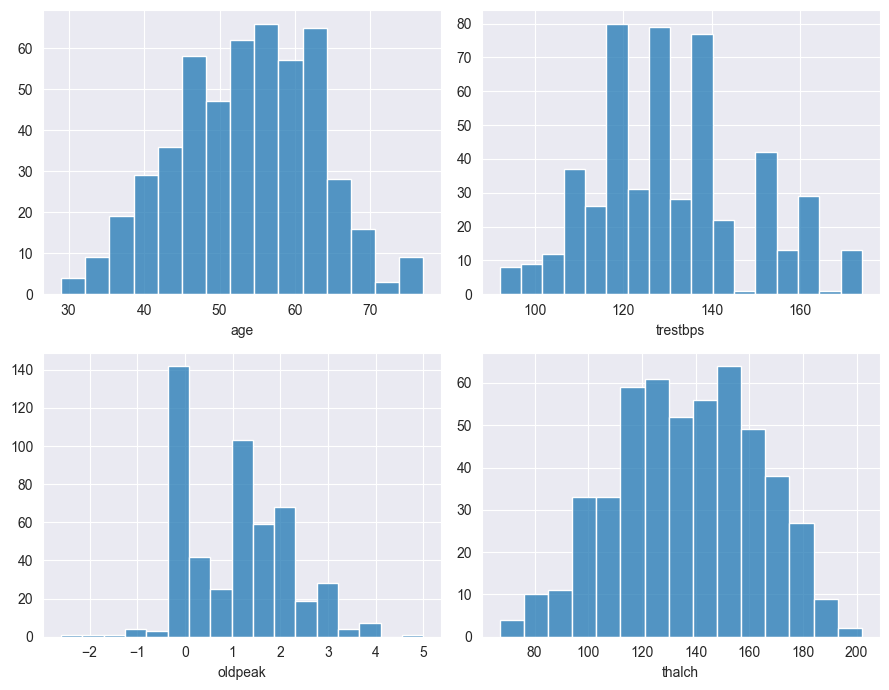

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7))

sns.histplot(x= heart_disease_df['age'], ax=ax[0,0])
sns.histplot(x= heart_disease_df['trestbps'], ax=ax[0,1])
sns.histplot(x= heart_disease_df['oldpeak'], ax=ax[1,0])
sns.histplot(x= heart_disease_df['thalch'], ax=ax[1,1])

for axes in ax.flat:
    axes.set_ylabel('')

plt.tight_layout()
plt.show()

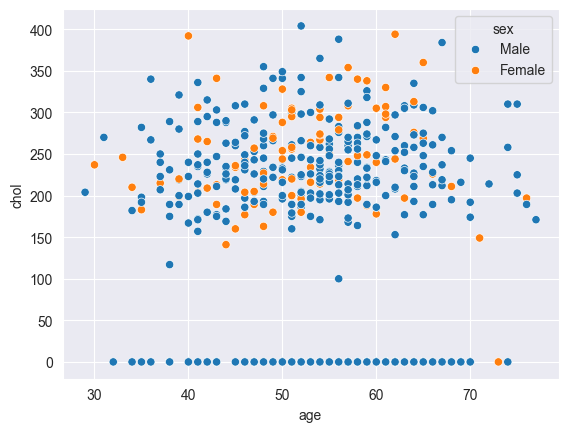

In [13]:
sns.scatterplot(heart_disease_df, x='age', y='chol', hue='sex')
plt.show()

<Figure size 2000x1600 with 0 Axes>

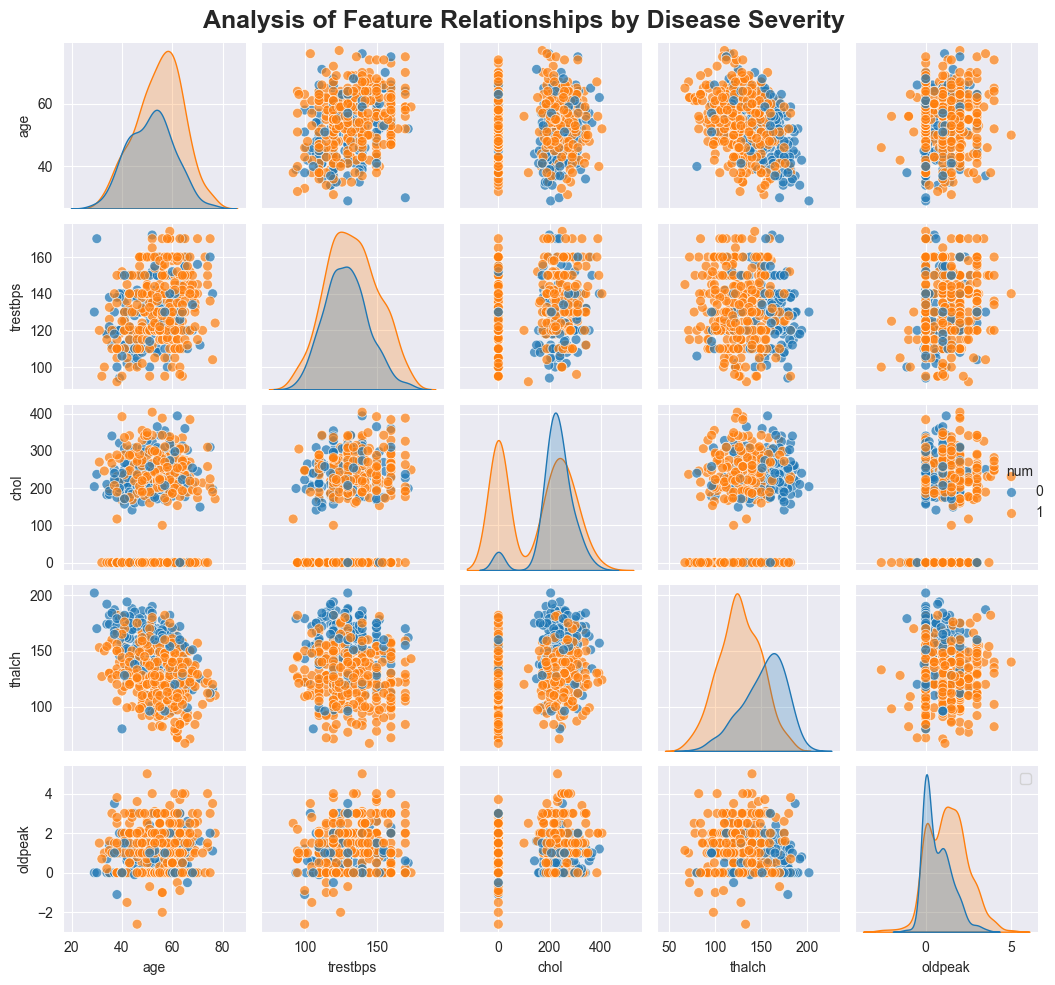

In [14]:
pairplot_data = heart_disease_df.drop(['fbs', 'exang', 'ca'], axis=1)
pairplot_data['num'] = pairplot_data['num'].astype('category')

plt.figure(figsize=(20,16))
sns.pairplot(pairplot_data, hue='num', diag_kind='kde', plot_kws={'alpha':0.7,'s':50}, height=2)
plt.suptitle('Analysis of Feature Relationships by Disease Severity', fontsize=18, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

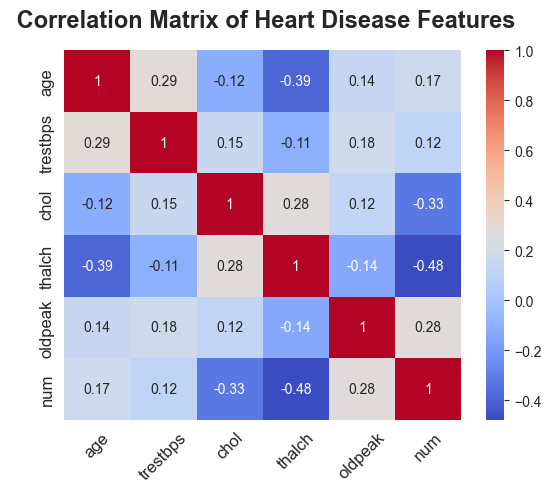

In [15]:
corr = heart_disease_df[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title(' Correlation Matrix of Heart Disease Features', y=1.04, fontsize=17, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data Preprocessing

### Encoding

In [16]:
heart_disease_df = pd.get_dummies(heart_disease_df, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype=int)

### Scaling

In [17]:
heart_disease_df_scaled = heart_disease_df.copy()

scaler = StandardScaler()
scale_clos = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
heart_disease_df_scaled[scale_clos] = scaler.fit_transform(heart_disease_df_scaled[scale_clos])

### Split X & Y

In [18]:
X = heart_disease_df_scaled.drop('num', axis=1)
y = heart_disease_df_scaled['num']

### Dimension Reduction (PCA)

In [19]:
pca = PCA(0.95)
X_pca = pca.fit_transform(X)
pca.n_components_

np.int64(13)

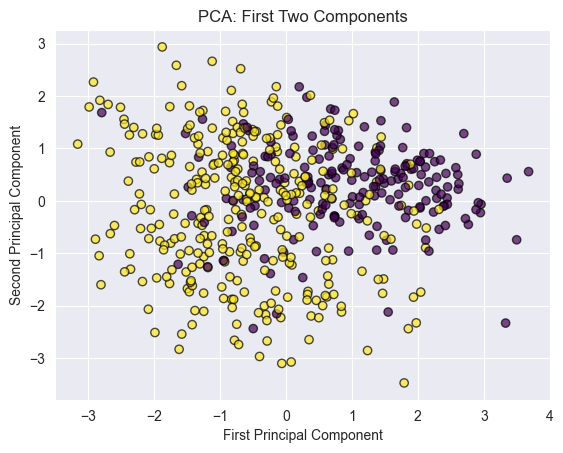

In [20]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=heart_disease_df['num'], cmap='viridis', alpha=0.7, edgecolor='k')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Components')
plt.show()

### Data Splitting

In [21]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42, stratify=y)

# Supervised Learning - Classification

## Logistic Reg

In [22]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_pred_prob_log = log_model.predict_proba(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_log))
print('f1_score',f1_score(y_test, y_pred_log))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_log))
print('precision_score',precision_score(y_test, y_pred_log))
print('recall_score',recall_score(y_test, y_pred_log))

print(classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log)
cm

accuracy_score 0.8582677165354331
f1_score 0.8875
balanced_accuracy_score 0.8428833071690214
precision_score 0.8658536585365854
recall_score 0.9102564102564102
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        49
           1       0.87      0.91      0.89        78

    accuracy                           0.86       127
   macro avg       0.86      0.84      0.85       127
weighted avg       0.86      0.86      0.86       127



array([[38, 11],
       [ 7, 71]])

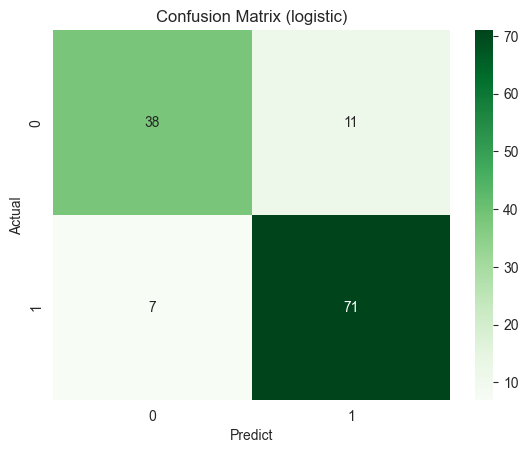

In [23]:
sns.heatmap(cm, cmap='Greens', annot=True)
plt.title('Confusion Matrix (logistic)')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

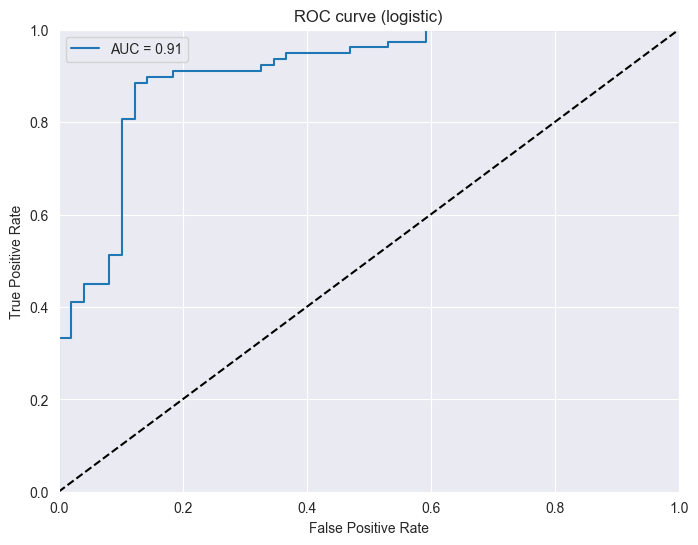

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_log[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve (logistic)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree

In [25]:
DT_model = DecisionTreeClassifier(criterion='gini', random_state=42)
DT_model.fit(X_train, y_train)

y_pred_DT = DT_model.predict(X_test)
y_pred_prob_DT = DT_model.predict_proba(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_DT))
print('f1_score',f1_score(y_test, y_pred_DT))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_DT))
print('precision_score',precision_score(y_test, y_pred_DT))
print('recall_score',recall_score(y_test, y_pred_DT))

print(classification_report(y_test, y_pred_DT))
cm = confusion_matrix(y_test, y_pred_DT)
cm

accuracy_score 0.7637795275590551
f1_score 0.8076923076923077
balanced_accuracy_score 0.750784929356358
precision_score 0.8076923076923077
recall_score 0.8076923076923077
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        49
           1       0.81      0.81      0.81        78

    accuracy                           0.76       127
   macro avg       0.75      0.75      0.75       127
weighted avg       0.76      0.76      0.76       127



array([[34, 15],
       [15, 63]])

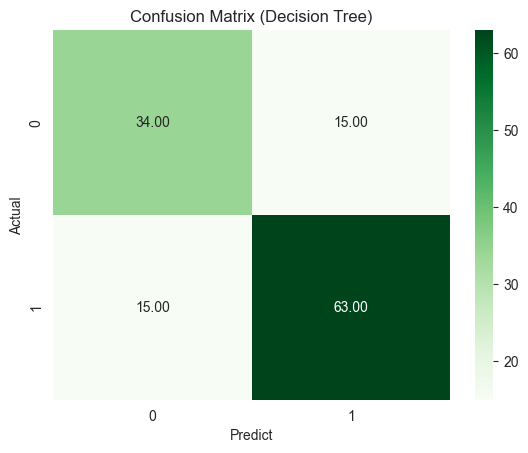

In [26]:
sns.heatmap(cm, cmap='Greens', annot=True, fmt='.2f')
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

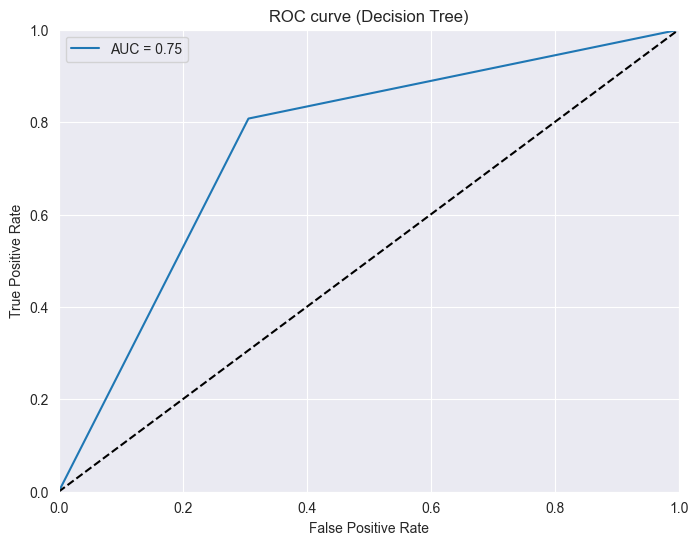

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_DT[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve (Decision Tree)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [28]:
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train, y_train)

y_pred_RF = RF_model.predict(X_test)
y_pred_prob_RF = RF_model.predict_proba(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_RF))
print('f1_score',f1_score(y_test, y_pred_RF))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_RF))
print('precision_score',precision_score(y_test, y_pred_RF))
print('recall_score',recall_score(y_test, y_pred_RF))

print(classification_report(y_test, y_pred_RF))
cm = confusion_matrix(y_test, y_pred_RF)
cm

accuracy_score 0.84251968503937
f1_score 0.8809523809523809
balanced_accuracy_score 0.8110936682365253
precision_score 0.8222222222222222
recall_score 0.9487179487179487
              precision    recall  f1-score   support

           0       0.89      0.67      0.77        49
           1       0.82      0.95      0.88        78

    accuracy                           0.84       127
   macro avg       0.86      0.81      0.82       127
weighted avg       0.85      0.84      0.84       127



array([[33, 16],
       [ 4, 74]])

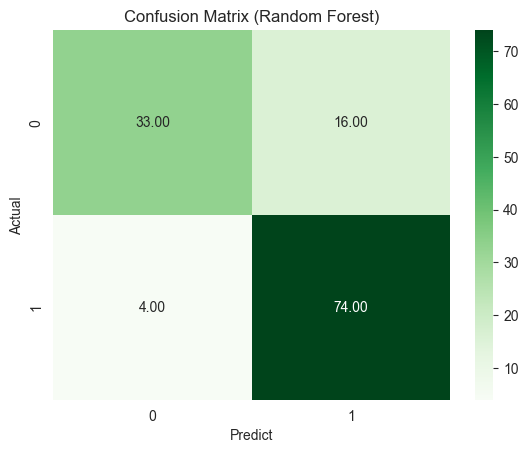

In [29]:
sns.heatmap(cm, cmap='Greens', annot=True, fmt='.2f')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

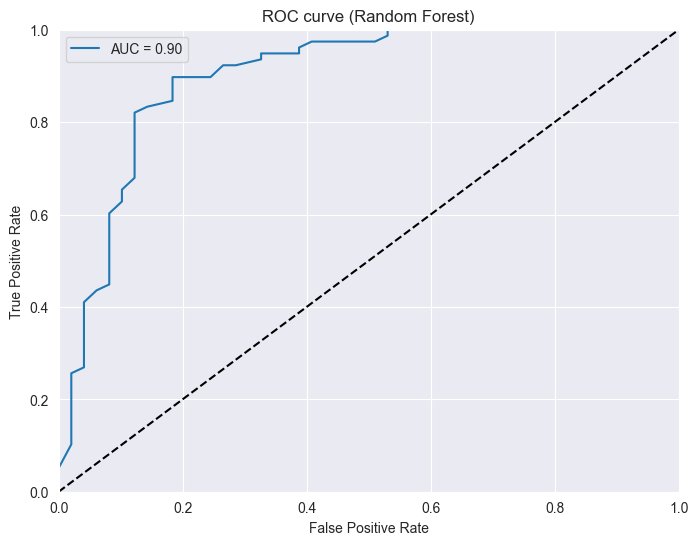

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_RF[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Support Vector Machine (SVM)

In [31]:
SVM_model = SVC(kernel='linear', degree=5, random_state=42)
SVM_model.fit(X_train, y_train)

y_pred_SVM = SVM_model.predict(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_SVM))
print('f1_score',f1_score(y_test, y_pred_SVM))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_SVM))
print('precision_score',precision_score(y_test, y_pred_SVM))
print('recall_score',recall_score(y_test, y_pred_SVM))

print(classification_report(y_test, y_pred_SVM))
cm = confusion_matrix(y_test, y_pred_SVM)
cm

accuracy_score 0.8582677165354331
f1_score 0.8875
balanced_accuracy_score 0.8428833071690214
precision_score 0.8658536585365854
recall_score 0.9102564102564102
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        49
           1       0.87      0.91      0.89        78

    accuracy                           0.86       127
   macro avg       0.86      0.84      0.85       127
weighted avg       0.86      0.86      0.86       127



array([[38, 11],
       [ 7, 71]])

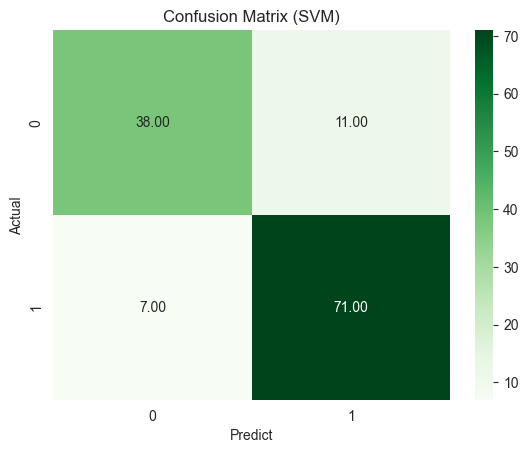

In [32]:
sns.heatmap(cm, cmap='Greens', annot=True, fmt='.2f')
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

## XGBoost

In [33]:
xgb_model = XGBClassifier(subsample=0.2, n_estimators=250, max_depth=3, learning_rate=0.01, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_xgb))
print('f1_score',f1_score(y_test, y_pred_xgb))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_xgb))
print('precision_score',precision_score(y_test, y_pred_xgb))
print('recall_score',recall_score(y_test, y_pred_xgb))

print(classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
cm

accuracy_score 0.8503937007874016
f1_score 0.8862275449101796
balanced_accuracy_score 0.8212977498691785
precision_score 0.8314606741573034
recall_score 0.9487179487179487
              precision    recall  f1-score   support

           0       0.89      0.69      0.78        49
           1       0.83      0.95      0.89        78

    accuracy                           0.85       127
   macro avg       0.86      0.82      0.83       127
weighted avg       0.86      0.85      0.85       127



array([[34, 15],
       [ 4, 74]])

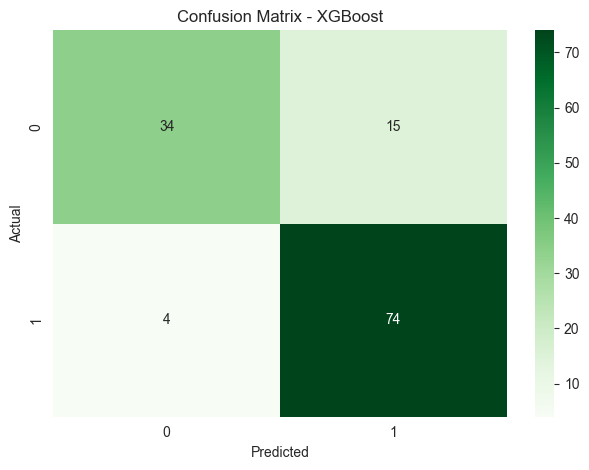

In [34]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')

plt.tight_layout()
plt.show()

## Voting Classifier

In [35]:
voting_model = VotingClassifier(estimators=[
    ('log_model', log_model),
    ('RF_model', RF_model),
    ('xgb_model', xgb_model)
], voting='hard')

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

print("accuracy_score",accuracy_score(y_test, y_pred_voting))
print('f1_score',f1_score(y_test, y_pred_voting))
print('balanced_accuracy_score',balanced_accuracy_score(y_test, y_pred_voting))
print('precision_score',precision_score(y_test, y_pred_voting))
print('recall_score',recall_score(y_test, y_pred_voting))

print(classification_report(y_test, y_pred_voting))
cm = confusion_matrix(y_test, y_pred_voting)
cm

accuracy_score 0.8503937007874016
f1_score 0.8848484848484849
balanced_accuracy_score 0.825091575091575
precision_score 0.8390804597701149
recall_score 0.9358974358974359
              precision    recall  f1-score   support

           0       0.88      0.71      0.79        49
           1       0.84      0.94      0.88        78

    accuracy                           0.85       127
   macro avg       0.86      0.83      0.84       127
weighted avg       0.85      0.85      0.85       127



array([[35, 14],
       [ 5, 73]])

## Hyperparameter Tuning

In [36]:
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

param_grid_DT = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

param_dist_RF = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_dist_SVM = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 5],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

param_dist_voting = {
    'log_model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'log_model__penalty': ['l1', 'l2', 'elasticnet', None],
    'log_model__solver': ['lbfgs', 'liblinear', 'saga'],
    'log_model__max_iter': [100, 500, 1000],

    'RF_model__n_estimators': [100, 200, 300],
    'RF_model__max_depth': [None, 10, 20, 30],
    'RF_model__min_samples_split': [2, 5, 10],
    'RF_model__min_samples_leaf': [1, 2, 4],
    'RF_model__bootstrap': [True, False],

    'xgb_model__n_estimators': [100, 200, 300],
    'xgb_model__max_depth': [3, 5, 7],
    'xgb_model__learning_rate': [0.01, 0.1, 0.2]
}


In [37]:
grid_log = GridSearchCV(log_model, param_grid=param_grid_log, cv=5, scoring='accuracy', n_jobs=-1)
grid_log.fit(X_train, y_train)
print('Best Score log:', grid_log.best_score_)
print('Best Params log:', grid_log.best_params_)

Best Score log: 0.8345522898154478
Best Params log: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [38]:
grid_DT = GridSearchCV(DT_model, param_grid=param_grid_DT, cv=5, scoring='accuracy', n_jobs=-1)
grid_DT.fit(X_train, y_train)
print('Best Score DT:', grid_DT.best_score_)
print('Best Params DT:', grid_DT.best_params_)

Best Score DT: 0.8004442925495556
Best Params DT: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}


In [39]:
grid_RF = RandomizedSearchCV(RF_model, param_distributions=param_dist_RF, cv=3, scoring='accuracy', n_jobs=-1)
grid_RF.fit(X_train, y_train)
print('Best Score RF:', grid_RF.best_score_)
print('Best Params RF:', grid_RF.best_params_)

Best Score RF: 0.8241469816272966
Best Params RF: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [40]:
grid_SVM = RandomizedSearchCV(SVM_model, param_distributions=param_dist_SVM, cv=5, scoring='accuracy', n_jobs=-1)
grid_SVM.fit(X_train, y_train)
print('Best Score SVM:', grid_SVM.best_score_)
print('Best Params SVM:', grid_SVM.best_params_)

Best Score SVM: 0.8240601503759398
Best Params SVM: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 1}


In [41]:
grid_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist_xgb, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print('Best Score xgb:', grid_xgb.best_score_)
print('Best Params xgb:', grid_xgb.best_params_)

Best Score xgb: 0.8241469816272966
Best Params xgb: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [42]:
grid_voting = RandomizedSearchCV(voting_model, param_distributions=param_dist_voting, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1)
grid_voting.fit(X_train, y_train)
print('Best Score voting:', grid_voting.best_score_)
print('Best Params voting:', grid_voting.best_params_)

Best Score voting: 0.8162729658792651
Best Params voting: {'xgb_model__n_estimators': 300, 'xgb_model__max_depth': 7, 'xgb_model__learning_rate': 0.01, 'log_model__solver': 'liblinear', 'log_model__penalty': 'l2', 'log_model__max_iter': 1000, 'log_model__C': 0.01, 'RF_model__n_estimators': 300, 'RF_model__min_samples_split': 10, 'RF_model__min_samples_leaf': 1, 'RF_model__max_depth': 20, 'RF_model__bootstrap': False}


## Evaluation Models

Final Model Evaluation:
                              Accuracy  F1-Score
Model                                           
Logistic Regression              85.83     88.75
Support Vector Machine (SVM)     85.83     88.75
Voting Classifier                85.04     88.48
XGBoost                          85.04     88.62
Random Forest                    84.25     88.10
Decision Tree                    76.38     80.77


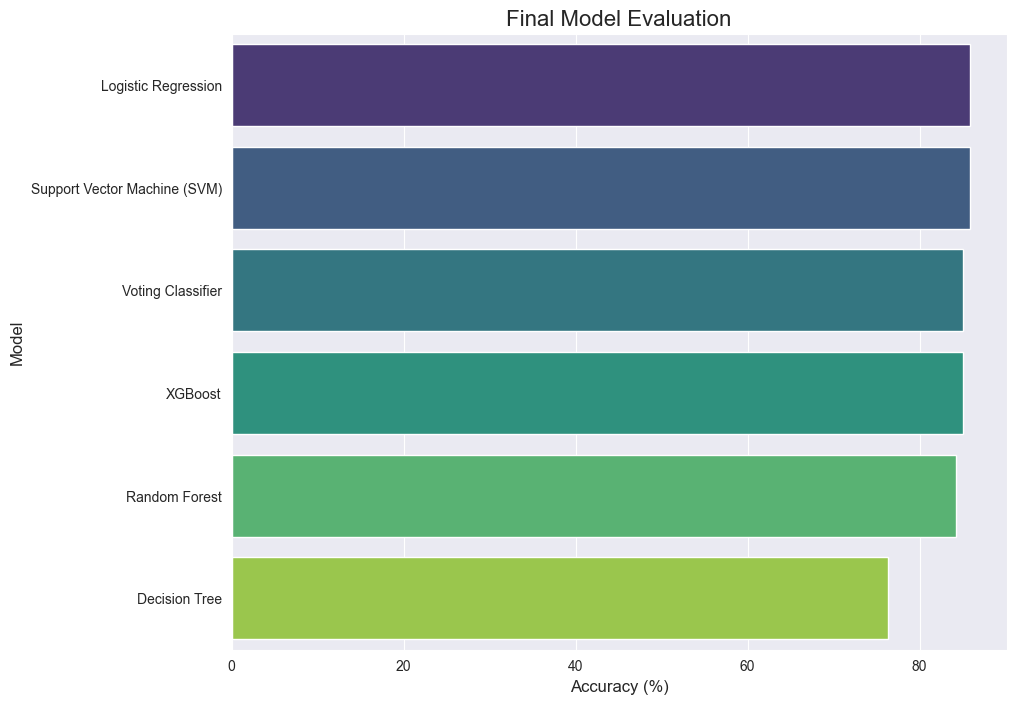

In [43]:
all_models = {
    'Model': [
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Support Vector Machine (SVM)', 'XGBoost', 'Voting Classifier'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_DT),
        accuracy_score(y_test, y_pred_RF), accuracy_score(y_test, y_pred_SVM),
        accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_voting)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_DT),
        f1_score(y_test, y_pred_RF), f1_score(y_test, y_pred_SVM),
        f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_voting)
    ]
}

performance_df = pd.DataFrame(all_models).set_index('Model').sort_values(by='Accuracy', ascending=False)

print('Final Model Evaluation:')
print((performance_df * 100).round(2))

plt.figure(figsize=(10, 8))
sns.barplot(x=performance_df['Accuracy'] * 100, y=performance_df.index, palette='viridis')
plt.title('Final Model Evaluation', fontsize=16)
plt.xlabel("Accuracy (%)", fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.show()

# Unsupervised Learning - Clustering

## KMeans

In [44]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans.fit(X_pca)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

print("Silhouette Score:", silhouette_score(X, labels))

Silhouette Score: 0.15522638381791395


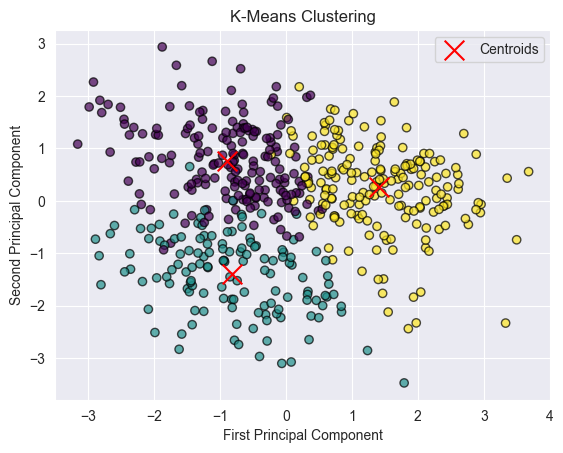

In [45]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolor='k')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

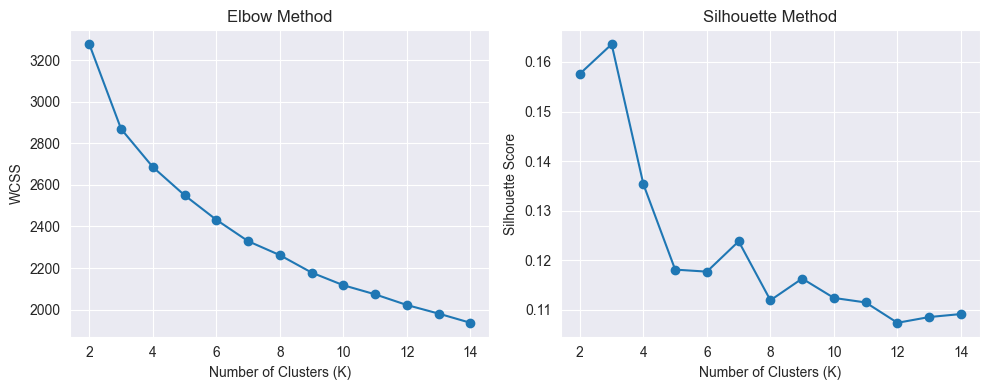

In [46]:
wcss = []
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(2, 15), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

## Hierarchical Clustering

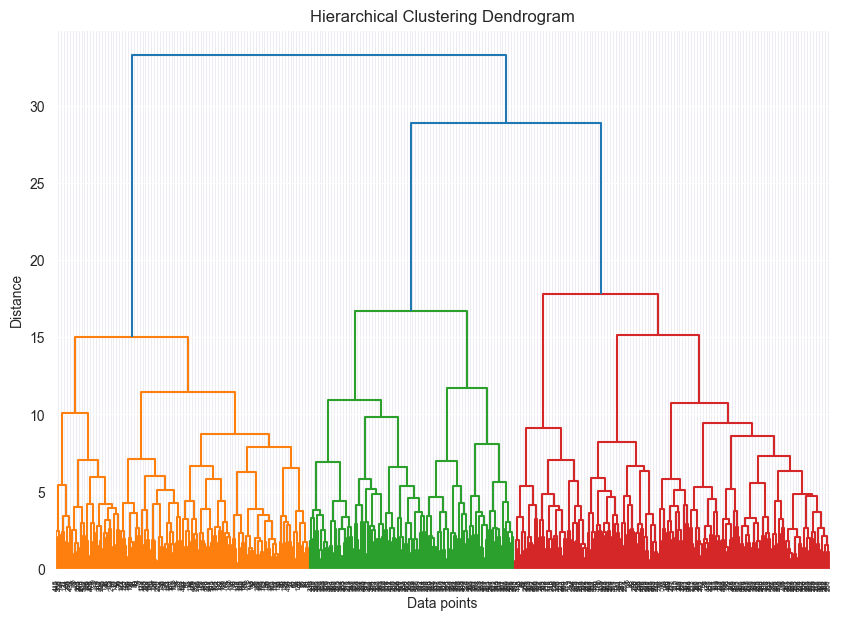

In [47]:
linkage_data = linkage(X_pca, method= 'ward', metric='euclidean')

plt.figure(figsize=(10, 7))
dendrogram(linkage_data)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()